In [1]:
import os

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

os.chdir(current_dir_path)

import pickle
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import statsmodels.api as sm
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic

from functions import *
from chi import *
from regressionP import *
from models import *

In [2]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("./Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("./Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1_new.csv")[:-2]

def preprocess(input_data, select_lst):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 7]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

In [4]:
select_lst = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    '死亡受傷人數'
]

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)
rbind_data = process_age(rbind_data)
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

In [5]:
with open('CalculatedData/道路V2_new.pkl', 'rb') as f:
    mapper_graph1 = pickle.load(f)
    
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['速限-第1當事者']].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 6,
    width = 800,
    height = 500)

In [6]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
        
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [7]:
calinski_data = get_calinski_from_db(full_info, 0.025)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_2 = full_info[full_info['label'] == 2]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 2) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_2 = get_count_dict(label_2)
count_out = get_count_dict(label_out)

full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]

# 離群值不需要被處理
full_out = rbind_data.loc[count_out.keys()]

lst01 = list(count_0.keys() & count_1.keys())
lst02 = list(count_0.keys() & count_2.keys())
lst12 = list(count_1.keys() & count_2.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())
lsto2 = list(count_out.keys() & count_2.keys())

# 將重複的key另外拉出進行分析，這裡drop是為了符合卡方的獨立性前提假設
full_01 = full_0.loc[lst01]
full_02 = full_0.loc[lst02]
full_12 = full_1.loc[lst12]

full_combine = pd.concat([full_01, full_02, full_12], axis=0) # full_out
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop(['受傷', '死亡', 'index'], axis=1)

In [8]:
full_combine.shape

(1499, 28)

In [9]:
full_out.shape

(391, 30)

In [10]:
select_lst = [
    '路面狀況-路面狀態名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者',
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', 
    '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
]

full_combine['label'] = 1
full_out['label'] = 0

labeled_data = pd.concat([full_combine, full_out])
labeled_data.reset_index(drop=True, inplace=True)

def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns=c0_for_lm.columns).reset_index(drop=True, inplace=False)
    # label設定
    c0_for_lm_y = cluster_data.apply(lambda row: 1 if row['label'] != 0 else 2, axis=1)
    # c0_for_lm_y = cluster_data['label']
        
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y


X, y = get_clusterN_logit(labeled_data, select_lst)

In [11]:
matrix_svc, score_svc, cm_svc = svc_cm_with_grid_search(X, y)
print(cm_svc)

[[110   3]
 [ 11 102]]


In [12]:
matrix_logistic, score_logistic, cm_logistic = logistic_cm_gridsearch(X, y)
print(cm_logistic)

[[111   2]
 [ 12 101]]


In [13]:
print(score_svc)
print(score_logistic)

0.9380530973451328
0.9380530973451328


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y.replace(2, 0), test_size=0.2, random_state=42)

logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

print(result.summary())

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.2f}")

Optimization terminated successfully.
         Current function value: 0.071536
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1512
Model:                          Logit   Df Residuals:                     1484
Method:                           MLE   Df Model:                           27
Date:                Sun, 29 Sep 2024   Pseudo R-squ.:                  0.8582
Time:                        11:02:17   Log-Likelihood:                -108.16
converged:                       True   LL-Null:                       -762.94
Covariance Type:            nonrobust   LLR p-value:                4.067e-259
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
路面狀況-路面狀態名稱                 0.2597      0.233      1.115      0.265      -0.197  

In [16]:
p_values = result.pvalues
significant_factors = p_values[p_values < 0.05]
significant_factors.sort_values()

速限-第1當事者                   6.223370e-25
事故類型及型態大類別名稱               7.978395e-17
車道劃分設施-分向設施大類別名稱           1.717622e-14
車道劃分設施-分道設施-路面邊線名稱         1.446991e-04
肇事逃逸類別名稱-是否肇逃              4.522042e-03
當事者行動狀態大類別名稱               1.054250e-02
車道劃分設施-分道設施-快車道或一般車道間名稱    1.088771e-02
道路型態大類別名稱                  1.262986e-02
當事者行動狀態子類別名稱               3.250291e-02
事故類型及型態子類別名稱               3.281463e-02
肇因研判大類別名稱-個別               3.474914e-02
dtype: float64

In [64]:
# plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # Window
plt.rcParams['font.sans-serif']=['Arial Unicode Ms'] # Mac
plt.rcParams['axes.unicode_minus'] = False

def plot_bar_comparison(df1, df2, feature, x_label, title, save_path):
    plt.figure(figsize=(14, 6))
    
    df1_counts = df1[feature].value_counts(normalize=True).reset_index()
    df2_counts = df2[feature].value_counts(normalize=True).reset_index()
    
    df1_counts['Source'] = 'Link'
    df2_counts['Source'] = 'Outlier'

    combined_counts = pd.concat([df1_counts, df2_counts])
    combined_counts.columns = [feature, 'Frequency', 'Source']

    ax = sns.barplot(data=combined_counts, x=feature, y='Frequency', hue='Source')
    plt.title(f'{feature} 頻率')
    plt.xticks(rotation=0)

    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate if height > 0
            ax.annotate(f'{height:.2%}', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', 
                        fontsize=10, color='black', xytext=(0, 5),
                        textcoords='offset points')

    ax.set_xlabel(x_label)
    ax.set_title(title)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

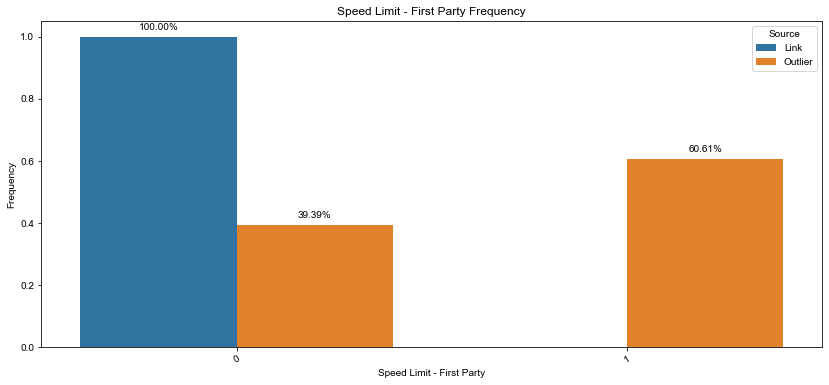

In [49]:
x_label = 'Speed Limit - First Party'
title = 'Speed Limit - First Party Frequency'
plot_bar_comparison(full_combine, full_out, '速限-第1當事者', x_label, title, save_path = 'CalculatedData/Plots/speed_frequency.png')

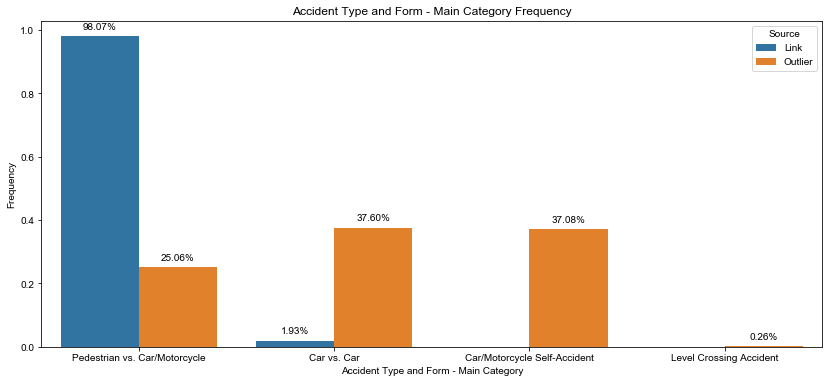

In [65]:
full_out['事故類型及型態大類別名稱'] = full_out['事故類型及型態大類別名稱'].replace({
    '車輛本身': 'Car/Motorcycle Self-Accident',
    '車與車': 'Car vs. Car',
    '人與車': 'Pedestrian vs. Car/Motorcycle',
    '平交道事故': 'Level Crossing Accident'
})
full_combine['事故類型及型態大類別名稱'] = full_combine['事故類型及型態大類別名稱'].replace({
    '車與車': 'Car vs. Car',
    '人與車': 'Pedestrian vs. Car/Motorcycle',
})
x_label = 'Accident Type and Form - Main Category'
title = 'Accident Type and Form - Main Category Frequency'
plot_bar_comparison(full_combine, full_out, '事故類型及型態大類別名稱', x_label, title, save_path = 'CalculatedData/Plots/accidenttype_frequency.png')

In [70]:
print(full_combine['車道劃分設施-分向設施大類別名稱'].unique())
print(full_out['車道劃分設施-分向設施大類別名稱'].unique())

['無' '行車分向線' '單向禁止超車線' '中央分向島' '雙向禁止超車線']
['中央分向島' '單向禁止超車線' '無' '雙向禁止超車線' '行車分向線']


In [ ]:
Double Yellow No-Passing Line, Central Median, Directional Line, Single Yellow No-Passing Line

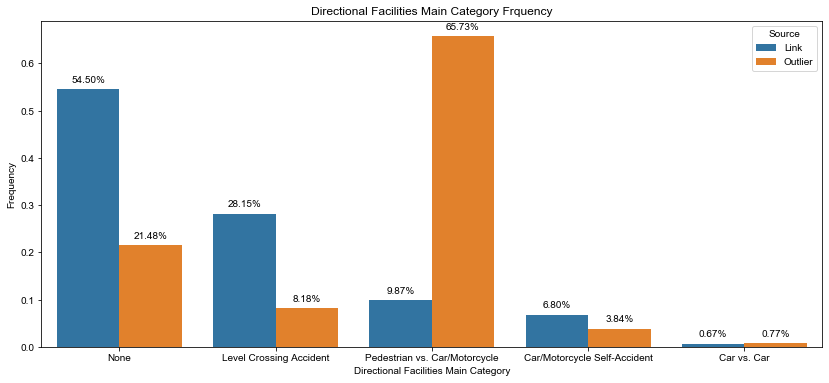

In [75]:
full_out['車道劃分設施-分向設施大類別名稱'] = full_out['車道劃分設施-分向設施大類別名稱'].replace({
    '行車分向線': 'Car/Motorcycle Self-Accident',
    '單向禁止超車線': 'Car vs. Car',
    '中央分向島': "Pedestrian vs. Car/Motorcycle",
    '雙向禁止超車線': 'Level Crossing Accident',
    '無': 'None'
})
full_combine['車道劃分設施-分向設施大類別名稱'] = full_combine['車道劃分設施-分向設施大類別名稱'].replace({
    '行車分向線': 'Car/Motorcycle Self-Accident',
    '單向禁止超車線': 'Car vs. Car',
    '中央分向島': "Pedestrian vs. Car/Motorcycle",
    '雙向禁止超車線': 'Level Crossing Accident',
    '無': 'None'
})
x_label = 'Directional Facilities Main Category'
title = 'Directional Facilities Main Category Frquency'
plot_bar_comparison(full_combine, full_out, '車道劃分設施-分向設施大類別名稱', x_label, title, save_path = 'CalculatedData/Plots/directionalfacilities_frequency.png')

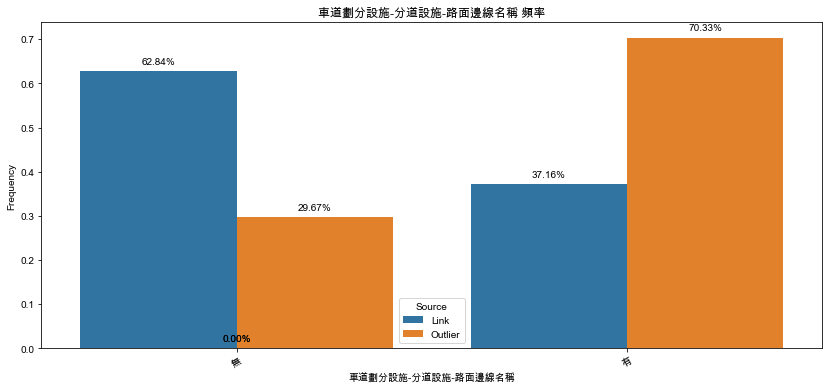

In [17]:
plot_bar_comparison(full_combine, full_out, '車道劃分設施-分道設施-路面邊線名稱')

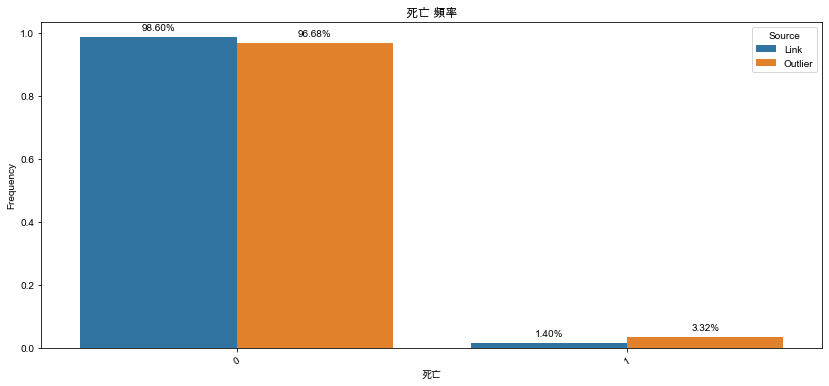

In [22]:
full_combine = pd.concat([full_01, full_02, full_12], axis=0) # full_out
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')

plot_bar_comparison(full_combine, full_out, '死亡')

In [23]:
full_combine['死亡'].value_counts()

0    1478
1      21
Name: 死亡, dtype: int64

In [24]:
full_out['死亡'].value_counts()

0    378
1     13
Name: 死亡, dtype: int64